# Trabalho Final

Student: Daniel da Silva Costa

E-mail: danieldasilvacosta@gmail.com

This notebook was built based on the codes from:

- What does a CNN see? https://www.kaggle.com/code/aakashnain/what-does-a-cnn-see/notebook
- tf.keras.layers.Conv2D
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D

In [1]:
data_folder = './data/'

# Imports

In [2]:
import os
import cv2
import glob
import imgaug as aug
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa
from os import listdir
from pathlib import Path
from keras.models import Sequential, Model
# from keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from keras import backend as K
from keras.applications.vgg16 import preprocess_input
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

color = sns.color_palette()
%matplotlib inline
%config InlineBackend.figure_format="svg"

from tensorflow.keras import layers, models

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
print(tf.__version__)

2.6.0


# Seed

In [5]:
os.environ['PYTHONHASHSEED'] = '0'

seed=1234

np.random.seed(seed)

tf.random.set_seed(seed)

aug.seed(seed)

# Organising the training and validation data

In [6]:
training_data = Path(data_folder + '/training/') 
validation_data = Path(data_folder + '/validation/') 
labels_path = Path(data_folder + '/monkey_labels.txt')

In [7]:
labels_info = []

lines = labels_path.read_text().strip().splitlines()[1:]
for line in lines:
    line = line.split(',')
    line = [x.strip(' \n\t\r') for x in line]
    line[3], line[4] = int(line[3]), int(line[4])
    line = tuple(line)
    labels_info.append(line)
    
labels_info = pd.DataFrame(labels_info, columns=['Label', 'Latin Name', 'Common Name', 
                                                 'Train Images', 'Validation Images'], index=None)
labels_info.head(10)

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata,mantled_howler,131,26
1,n1,erythrocebus_patas,patas_monkey,139,28
2,n2,cacajao_calvus,bald_uakari,137,27
3,n3,macaca_fuscata,japanese_macaque,152,30
4,n4,cebuella_pygmea,pygmy_marmoset,131,26
5,n5,cebus_capucinus,white_headed_capuchin,141,28
6,n6,mico_argentatus,silvery_marmoset,132,26
7,n7,saimiri_sciureus,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


In [8]:
labels_dict= {'n0':0, 'n1':1, 'n2':2, 'n3':3, 'n4':4, 'n5':5, 'n6':6, 'n7':7, 'n8':8, 'n9':9}

names_dict = dict(zip(labels_dict.values(), labels_info["Common Name"]))
print(names_dict)

{0: 'mantled_howler', 1: 'patas_monkey', 2: 'bald_uakari', 3: 'japanese_macaque', 4: 'pygmy_marmoset', 5: 'white_headed_capuchin', 6: 'silvery_marmoset', 7: 'common_squirrel_monkey', 8: 'black_headed_night_monkey', 9: 'nilgiri_langur'}


In [9]:
train_df = []
for folder in os.listdir(training_data):
    imgs_path = training_data / folder
    
    imgs = sorted(imgs_path.glob('*.jpg'))
    
    for img_name in imgs:
        train_df.append((str(img_name), labels_dict[folder]))


train_df = pd.DataFrame(train_df, columns=['image', 'label'], index=None)
train_df = train_df.sample(frac=1.).reset_index(drop=True)

In [10]:
valid_df = []
for folder in os.listdir(validation_data):
    imgs_path = validation_data / folder
    imgs = sorted(imgs_path.glob('*.jpg'))
    for img_name in imgs:
        valid_df.append((str(img_name), labels_dict[folder]))

        
valid_df = pd.DataFrame(valid_df, columns=['image', 'label'], index=None)
# shuffle the dataset 
valid_df = valid_df.sample(frac=1.).reset_index(drop=True)

In [11]:
print("Number of traininng samples: ", len(train_df))
print("Number of validation samples: ", len(valid_df))

print("\n",train_df.head(), "\n")
print("=================================================================\n")
print("\n", valid_df.head())

Number of traininng samples:  1097
Number of validation samples:  272

                         image  label
0  data\training\n0\n0134.jpg      0
1  data\training\n4\n4114.jpg      4
2  data\training\n4\n4059.jpg      4
3  data\training\n3\n3061.jpg      3
4  data\training\n0\n0150.jpg      0 



                           image  label
0   data\validation\n2\n218.jpg      2
1  data\validation\n3\n3013.jpg      3
2  data\validation\n2\n2011.jpg      2
3   data\validation\n6\n608.jpg      6
4   data\validation\n6\n605.jpg      6


# batch_size and some important constants

In [12]:
batch_size = 128

In [13]:
img_rows, img_cols, img_channels = 224,224,3

In [14]:
num_classes = 10

# Creating the data generators to be used in the training stage

## Augmentation pipeline

In [15]:
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=20), # roatation
    iaa.Multiply((1.2, 1.5))]) #random brightness

## def data_generator(data, batch_size, is_validation_data=False):

In [16]:
def data_generator(data, batch_size, is_validation_data=False):
    
    n = len(data)
    nb_batches = int(np.ceil(n/batch_size))

    indices = np.arange(n)
    
    batch_data = np.zeros((batch_size, img_rows, img_cols, img_channels), dtype=np.float32)
    batch_labels = np.zeros((batch_size, num_classes), dtype=np.float32)
    
    while True:
        if not is_validation_data:
            np.random.shuffle(indices)
            
        for i in range(nb_batches):
            next_batch_indices = indices[i*batch_size:(i+1)*batch_size]
            
            for j, index in enumerate(next_batch_indices):
                img = cv2.imread(data.iloc[index]["image"])
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                label = data.iloc[index]["label"]
                
                if not is_validation_data:
                    img = seq.augment_image(img)
                
                img = cv2.resize(img, (img_rows, img_cols)).astype(np.float32)
                batch_data[j] = img
                batch_labels[j] = to_categorical(label,num_classes=num_classes)
            
            batch_data = preprocess_input(batch_data)
            yield batch_data, batch_labels

In [17]:
train_data_gen = data_generator(train_df, batch_size)

valid_data_gen = data_generator(valid_df, batch_size, is_validation_data=True)

# Model

## kernel_size

In [18]:
kernel_size = 1

## Net Architecture

In [19]:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D
# tf.keras.layers.Conv2D( filters, kernel_size, ...)

model = models.Sequential([
    layers.InputLayer( input_shape=(224, 224, 3) )
])

### 1 conv layer
model.add( layers.Conv2D(16, (kernel_size, kernel_size), 
                        padding='same',
                        activation='relu') )
model.add( layers.MaxPooling2D((2, 2)) )

### 2 conv layer
model.add( layers.Conv2D(32, (kernel_size, kernel_size), 
                        padding='same',
                        activation='relu') )
model.add( layers.MaxPooling2D((2, 2)) )

### 3 conv layer
model.add( layers.Conv2D(64, (kernel_size, kernel_size), 
                        padding='same',
                        activation='relu') )
model.add( layers.MaxPooling2D((2, 2)) )

### 4 conv layer
model.add( layers.Conv2D(128, (kernel_size, kernel_size), 
                        padding='same',
                        activation='relu') )
model.add( layers.MaxPooling2D((2, 2)) )

### 5 conv layer
model.add( layers.Conv2D(256, (kernel_size, kernel_size), 
                        padding='same',
                        activation='relu') )
model.add( layers.MaxPooling2D((2, 2)) )

### 6 fully layers
model.add( layers.Flatten() )
model.add( layers.Dropout(0.2) )
model.add( layers.Dense(10, activation='softmax') )

# To correct some bug on input
model = Model(model.input, model.output)

optimizer = RMSprop(0.001)
model.compile(optimizer = optimizer, 
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      544       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        2112      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0     

# Setup to Training

## EarlyStopping and ModelCheckpoint

In [20]:
early_stopping = EarlyStopping(patience=20, restore_best_weights=True)

model_checkpoint = ModelCheckpoint(filepath="model1", save_best_only=True)

num_train_steps = int(np.ceil(len(train_df)/batch_size))
num_valid_steps = int(np.ceil(len(valid_df)/batch_size))

## Epochs

In [21]:
epochs=100
# epochs=5

## Training

In [22]:
%%time

training_result = model.fit(train_data_gen, 
                              epochs = epochs, 
                              steps_per_epoch = num_train_steps, 
                              validation_data = valid_data_gen, 
                              validation_steps = num_valid_steps,
                              callbacks = [early_stopping, model_checkpoint])

Epoch 1/100
9/9 [==============================] - ETA: 0s - batch: 4.0000 - size: 128.0000 - loss: 34.5792 - accuracy: 0.1233

C:\Users\danie\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


INFO:tensorflow:Assets written to: model1\assets
9/9 [==============================] - 35s 4s/step - batch: 4.0000 - size: 128.0000 - loss: 34.5792 - accuracy: 0.1233 - val_loss: 5.7049 - val_accuracy: 0.1380
Epoch 2/100
9/9 [==============================] - 27s 3s/step - batch: 4.0000 - size: 128.0000 - loss: 3.8801 - accuracy: 0.1589 - val_loss: 4.4385 - val_accuracy: 0.1797
Epoch 3/100
9/9 [==============================] - 27s 3s/step - batch: 4.0000 - size: 128.0000 - loss: 2.8782 - accuracy: 0.2587 - val_loss: 2.1101 - val_accuracy: 0.2760
Epoch 4/100
9/9 [==============================] - 25s 3s/step - batch: 4.0000 - size: 128.0000 - loss: 2.1715 - accuracy: 0.2891 - val_loss: 2.3540 - val_accuracy: 0.3125
Epoch 5/100
9/9 [==============================] - 27s 3s/step - batch: 4.0000 - size: 128.0000 - loss: 1.9327 - accuracy: 0.3316 - val_loss: 2.4512 - val_accuracy: 0.2943
Epoch 6/100
9/9 [==============================] - 27s 3s/step - batch: 4.0000 - size: 128.0000 - loss

# Results

In [23]:
training_result.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

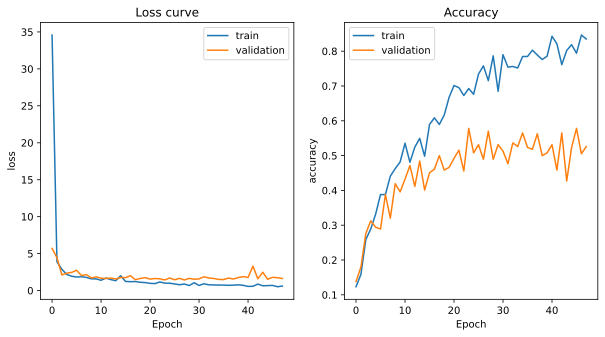

In [24]:
train_acc = training_result.history['accuracy']
valid_acc = training_result.history['val_accuracy']

train_loss = training_result.history['loss']
valid_loss = training_result.history['val_loss']

xvalues = np.arange(len(train_acc))

f,ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(xvalues, train_loss)
ax[0].plot(xvalues, valid_loss)
ax[0].set_title("Loss curve")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("loss")
ax[0].legend(['train', 'validation'])

ax[1].plot(xvalues, train_acc)
ax[1].plot(xvalues, valid_acc)
ax[1].set_title("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("accuracy")
ax[1].legend(['train', 'validation'])

plt.show()

In [25]:
valid_loss, valid_acc = model.evaluate_generator(valid_data_gen, steps=num_valid_steps)
print(f"Final validation accuracy: {valid_acc*100:.2f}%")

C:\Users\danie\anaconda3\envs\tf\lib\site-packages\keras\engine\training_v1.py:1261: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


RuntimeError: Your generator is NOT thread-safe. Keras requires a thread-safe generator when `use_multiprocessing=False, workers > 1`. 

In [ ]:
outputs = [layer.output for layer in model.layers[1:18]]

vis_model = Model(model.input, outputs)

for layer in vis_model.layers:
    layer.trainable = False

# vis_model.summary()

In [ ]:
layer_names = []
for layer in outputs:
    layer_names.append(layer.name.split("/")[0])

    
print("Layers going to be used for visualization: ")
print(layer_names)

In [ ]:
print( f'layer_names [before]: {layer_names}' )

layer_names_temp = layer_names
layer_names = list()
for layer in layer_names_temp:
    
    if 'conv' in layer:
        # print(layer)
        layer_names.append( layer )

print( '==================================================================================' )
print( f'layer_names [after]: {layer_names}' )

In [ ]:
def get_CAM(processed_image, predicted_label):

    predicted_output = model.output[:, predicted_label]
    
    last_conv_layer = model.get_layer(layer_names[-1])
    
    # get the gradients wrt to the last conv layer
    grads = K.gradients(predicted_output, last_conv_layer.output)[0]
    
    # take mean gradient per feature map
    grads = K.mean(grads, axis=(0,1,2)) # GAP - Global Average Pooling
    
    # Define a function that generates the values for the output and gradients
    evaluation_function = K.function([model.input], [grads, last_conv_layer.output[0]])
    
    # get the values
    grads_values, conv_ouput_values = evaluation_function([processed_image])
    
    # CAM - Class Activation Map
    # iterate over each feature map in your conv output and multiply
    # the gradient values with the conv output values. This gives an 
    # indication of "how important a feature is"
    # for i in features in the last conv layer.
    for i in range(conv_ouput_values.shape[2]):
        conv_ouput_values[:,:,i] *= grads_values[i]
    
    heatmap = np.mean(conv_ouput_values, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= heatmap.max()
    
    return heatmap

# Examples

In [ ]:
for index in range(0, 10):

    sample_image = cv2.imread(valid_df.iloc[index]['image'])
    sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
    sample_image = cv2.resize(sample_image, (img_rows, img_cols))
    sample_label = valid_df.iloc[index]["label"]

    sample_image_processed = np.expand_dims(sample_image, axis=0)
    sample_image_processed = preprocess_input(sample_image_processed)

    pred_label = np.argmax(model.predict(sample_image_processed), axis=-1)[0]

    heatmap = get_CAM(sample_image_processed, pred_label)
    heatmap = cv2.resize(heatmap, (sample_image.shape[0], sample_image.shape[1]))
    heatmap = heatmap *255
    heatmap = np.clip(heatmap, 0, 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    super_imposed_image = heatmap * 0.5 + sample_image
    super_imposed_image = np.clip(super_imposed_image, 0,255).astype(np.uint8)
    
    fontsize = 10
    fig, axes = plt.subplots( 1, 3, figsize=( 8, 8 ) )
    axes[0].set_title( f'True label: {sample_label} \n Predicted label: {pred_label}',
                      fontsize = fontsize )
    axes[0].axis('off')
    axes[0].imshow( sample_image )

    axes[1].set_title( f'Class Activation Map',
                      fontsize = fontsize )
    axes[1].axis('off')
    axes[1].imshow( heatmap )

    axes[2].set_title( f'Activation Map Superimposed',
                      fontsize = fontsize )
    axes[2].axis('off')
    axes[2].imshow( super_imposed_image )
    plt.show()

    # # Plot just CAM of the layer
    # plt.figure( figsize=(2, 2) )
    # plt.title( f'Class Activation Map - Layer: {layer}' )
    # plt.imshow( heatmap )
    # plt.show()